In [ ]:
 ! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
 ! cp /content/drive/MyDrive/Colab_Notebooks/kaggle_api_credential/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download fitriakd/cattle-feet-dataset

 90% 127M/142M [00:02<00:00, 66.5MB/s]
100% 142M/142M [00:02<00:00, 70.9MB/s]


In [ ]:
! unzip /content/cattle-feet-dataset.zip


Archive:  /content/cattle-feet-dataset.zip
  inflating: Feet/fmd/augmented_fmdf_0 (2).jpg  
  inflating: Feet/fmd/augmented_fmdf_0 (3).jpg  
  inflating: Feet/fmd/augmented_fmdf_0 (4).jpg  
  inflating: Feet/fmd/augmented_fmdf_0 (5).jpg  
  inflating: Feet/fmd/augmented_fmdf_0 (6).jpg  
  inflating: Feet/fmd/augmented_fmdf_0.jpg  
  inflating: Feet/fmd/augmented_fmdf_1 (2).jpg  
  inflating: Feet/fmd/augmented_fmdf_1 (3).jpg  
  inflating: Feet/fmd/augmented_fmdf_1 (4).jpg  
  inflating: Feet/fmd/augmented_fmdf_1 (5).jpg  
  inflating: Feet/fmd/augmented_fmdf_1 (6).jpg  
  inflating: Feet/fmd/augmented_fmdf_1.jpg  
  inflating: Feet/fmd/augmented_fmdf_10 (2).jpg  
  inflating: Feet/fmd/augmented_fmdf_10 (3).jpg  
  inflating: Feet/fmd/augmented_fmdf_10 (4).jpg  
  inflating: Feet/fmd/augmented_fmdf_10 (5).jpg  
  inflating: Feet/fmd/augmented_fmdf_10 (6).jpg  
  inflating: Feet/fmd/augmented_fmdf_10.jpg  
  inflating: Feet/fmd/augmented_fmdf_11 (2).jpg  
  inflating: Feet/fmd/augmented

In [ ]:
#Import the libraries
import zipfile
import os
import shutil
import random
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

#zip_ref = zipfile.ZipFile('/content/drive/MyDrive/NETKIT BISA/datasets/dataset_feet.zip', 'r') #Opens the zip file in read mode
#zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
#zip_ref.close()

In [ ]:
# directories
dir_list = ['/Feet/fmd', '/Feet/healthy']

base_dir = '/tmp/dataset'
train_dir = '/tmp/dataset/train/'
test_dir = '/tmp/dataset/test/'

train_aug = '/tmp/augmented/train/'
test_aug = '/tmp/augmented/test/'

classes = ['fmd_feet', 'healthy_feet']

In [ ]:
# Create new folders
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

for i in classes:
  os.mkdir(os.path.join(train_dir,i))
for k in classes:
  os.mkdir(os.path.join(test_dir,k))


In [ ]:
# FUNCTION: split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  # Shuffle list
  shuffled_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))

  # Find total number of files in training dir
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING

  for item in shuffled_source:
    item_source = os.path.join(SOURCE, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING
    if i == training_number:
      target = TESTING



In [ ]:
# Test your split_data function

# Define paths
FMDF_SOURCE_DIR = "/content/Feet/fmd"
HEALTHYF_SOURCE_DIR = "/content/Feet/healthy"

TRAINING_DIR = "/tmp/dataset/train"
TESTING_DIR = "/tmp/dataset/test"

TRAINING_FMDF_DIR = "/tmp/dataset/train/fmd_feet"
TESTING_FMDF_DIR = "/tmp/dataset/test/fmd_feet"

TRAINING_HEALTHYF_DIR = "/tmp/dataset/train/healthy_feet"
TESTING_HEALTHYF_DIR = "/tmp/dataset/test/healthy_feet"


# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_HEALTHYF_DIR)) > 0:
  for file in os.scandir(TRAINING_HEALTHYF_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FMDF_DIR)) > 0:
  for file in os.scandir(TRAINING_FMDF_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_HEALTHYF_DIR)) > 0:
  for file in os.scandir(TESTING_HEALTHYF_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FMDF_DIR)) > 0:
  for file in os.scandir(TESTING_FMDF_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(FMDF_SOURCE_DIR, TRAINING_FMDF_DIR, TESTING_FMDF_DIR, split_size)
split_data(HEALTHYF_SOURCE_DIR, TRAINING_HEALTHYF_DIR, TESTING_HEALTHYF_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_HEALTHYF_DIR))} images of healthy feet for training")
print(f"There are {len(os.listdir(TRAINING_FMDF_DIR))} images of fmd feet for training")
print(f"There are {len(os.listdir(TESTING_HEALTHYF_DIR))} images of healthy feet for testing")
print(f"There are {len(os.listdir(TESTING_FMDF_DIR))} images of fmd feet for testing")



There are 172 images of healthy feet for training
There are 159 images of fmd feet for training
There are 44 images of healthy feet for testing
There are 40 images of fmd feet for testing


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 60,
                                     width_shift_range = 0.4,
                                     height_shift_range = 0.4,
                                     shear_range = 0.4,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 20,
                                                      class_mode = 'binary',
                                                      target_size = (150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 10,
                                                                class_mode = 'binary',
                                                                target_size = (150, 150))
  ### END CODE HERE
  return train_generator, validation_generator


In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)


Found 331 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


In [ ]:
class myCallback(keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end

        def on_epoch_end(self, epoch, logs=None):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
                print("\nReached 99% accuracy so cancelling training!")

                # Stop training once the above condition is met
                self.model.stop_training = True

In [ ]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

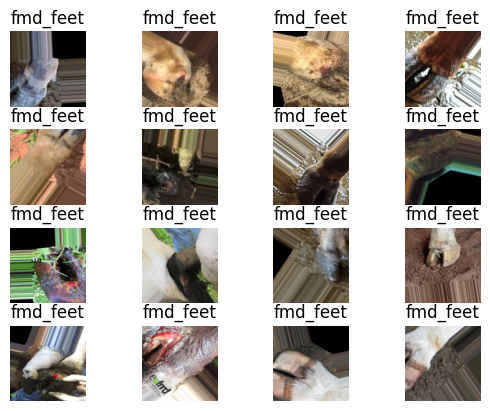

In [ ]:
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
  plt.imshow(images[i])
  plt.title(f'{labels[np.argmax(titles[i],axis=0)]}')
  plt.axis("off")

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
inc_history = model.fit_generator(train_generator,
                                  validation_data = validation_generator,
                                  epochs = 50)

<ipython-input-20-c1db79026b55>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  inc_history = model.fit_generator(train_generator,


Epoch 1/50
17/17 [==============================] - 32s 1s/step - loss: 4.9501 - acc: 0.5831 - val_loss: 0.4507 - val_acc: 0.8690
Epoch 2/50
17/17 [==============================] - 12s 710ms/step - loss: 0.7247 - acc: 0.7764 - val_loss: 0.6762 - val_acc: 0.7619
Epoch 3/50
17/17 [==============================] - 13s 771ms/step - loss: 0.7242 - acc: 0.7915 - val_loss: 0.1940 - val_acc: 0.9286
Epoch 4/50
17/17 [==============================] - 13s 765ms/step - loss: 0.6252 - acc: 0.8308 - val_loss: 0.1009 - val_acc: 0.9881
Epoch 5/50
17/17 [==============================] - 14s 820ms/step - loss: 0.6360 - acc: 0.8127 - val_loss: 0.1619 - val_acc: 0.9405
Epoch 6/50
17/17 [==============================] - 13s 757ms/step - loss: 0.5859 - acc: 0.8338 - val_loss: 0.0881 - val_acc: 0.9881
Epoch 7/50
17/17 [==============================] - 14s 871ms/step - loss: 0.2111 - acc: 0.9245 - val_loss: 0.2816 - val_acc: 0.8810
Epoch 8/50
17/17 [==============================] - 15s 903ms/step - los

In [ ]:
from keras.api._v2.keras import callbacks
# Get the untrained model

base_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

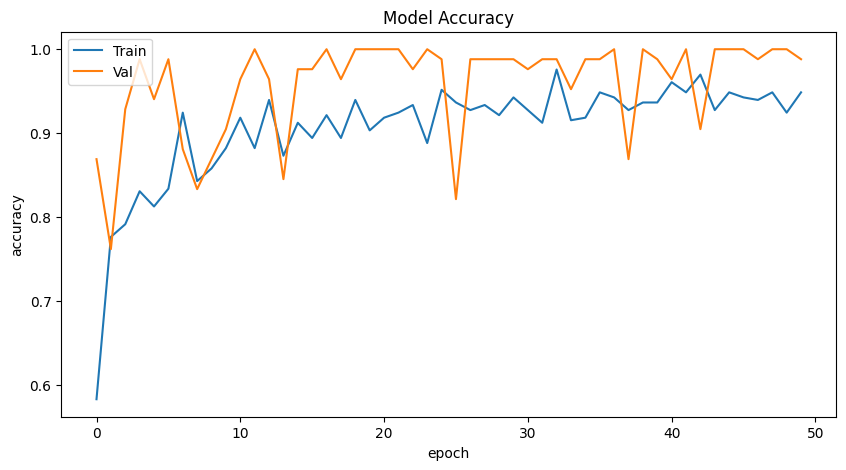

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(inc_history.history['acc'])
plt.plot(inc_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

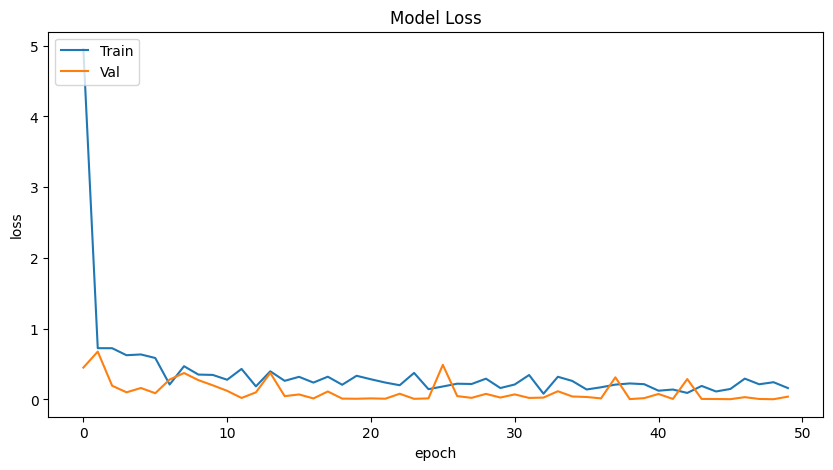

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(inc_history.history['loss'])
plt.plot(inc_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  percent = "{:.2f}".format(100 - classes[0][0]*100)
  print("Health Percentage: %.2f%%" % (classes[0]*100))

Saving download (9).jfif to download (9).jfif
1/1 [==============================] - 0s 25ms/step
[0.99885166]
Health Percentage: 99.89%


In [ ]:
if classes[0]>0.5:
  print("Sapi Anda tidak mengalami gejala PMK berdasarkan pemindaian pada kaki.")
else:
  print("Sapi Anda memiliki kemungkinan mengalami PMK berdasarkan gejala pada kaki sebesar " + percent + "%.")

Sapi Anda tidak mengalami gejala PMK berdasarkan pemindaian pada kaki.


In [ ]:
model.save("inc_model_feet.h5")